1. Install dependencies/decompress data sets

    You need to pip paddleseg before each run
    The data set does not need to be decompressed repeatedly. The original aerial imagery data of the Aerial imagery dataset comes from the New Zealand Land Information Service website. This aerial imagery (including 187,000 buildings) is down-sampled to a ground resolution of 0.3m and cropped into 8189 tiles of 512×512 pixels. The original training set, validation set and test set are merged here (the original data comes from the Photogrammetry and Computer Vision Group (GPCV) of Wuhan University-Ji Shunping. Introduction to Intelligent Photogrammetry [M], Science Press, 2018. 4 moon.

In [ ]:
! pip install paddleseg
# ! unzip -q /home/aistudio/data/data69911/BuildData.zip -d DataSet

2. Generate data list

Generate training set and test set according to 9:1, after the data list is generated, there is no need to run this module repeatedly


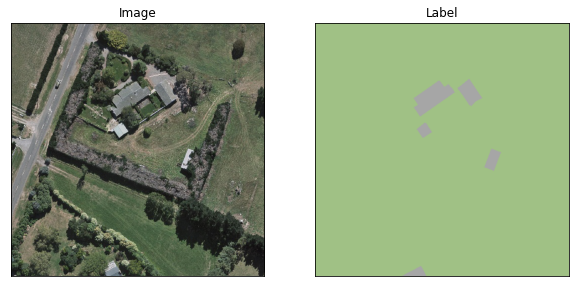

In [9]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def create_list(data_path):
    image_path = os.path.join(data_path, 'image')
    label_path = os.path.join(data_path, 'label')
    data_names = os.listdir(image_path)
    random.shuffle(data_names)  # 打乱数据
    with open(os.path.join(data_path, 'train_list.txt'), 'w') as tf:
        with open(os.path.join(data_path, 'val_list.txt'), 'w') as vf:
            for idx, data_name in enumerate(data_names):
                img = os.path.join('image', data_name)
                lab = os.path.join('label', data_name.replace('jpg', 'png'))
                if idx % 9 == 0:  # 90%的作为训练集
                    vf.write(img + ' ' + lab + '\n')
                else:
                    tf.write(img + ' ' + lab + '\n')
    print('数据列表生成完成')

data_path = 'DataSet'
# create_list(data_path)  # 生成数据列表

# 查看一组数据
vis_img = Image.open('DataSet/image/0045.jpg')
vis_lab = Image.open('DataSet/label/0045.png')
plt.figure(figsize=(10, 20))
plt.subplot(121);plt.imshow(vis_img);plt.xticks([]);plt.yticks([]);plt.title('Image')
plt.subplot(122);plt.imshow(vis_lab);plt.xticks([]);plt.yticks([]);plt.title('Label')
plt.show()

3. Train the network

Using the Unet++ network provided by PaddleSeg, the author of this network knows the design concept of Unet++ very clearly. Compared with the original Unet network, in order to avoid the fusion of the semantically dissimilar features of pure jump connections in UNet, UNet++ further strengthens these connections by introducing nested and dense jump connections, with the purpose of reducing encoders and decoding Semantic gap

In [10]:
import paddle
from paddleseg.models import UNetPlusPlus
import paddleseg.transforms as T
from paddleseg.datasets import Dataset
from paddleseg.models.losses import BCELoss
from paddleseg.core import train

def train_model(base_lr=0.00001, iters=10000, batch_size=8, model_path=None):
    # 网络定义
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    if model_path is not None:
        para_state_dict = paddle.load(model_path)
        model.set_dict(para_state_dict)
    # 构建训练集
    train_transforms = [
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(),
        T.RandomScaleAspect(),
        T.RandomDistort(),
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ]
    train_dataset = Dataset(
        transforms=train_transforms,
        dataset_root='DataSet',
        num_classes=2,
        mode='train',
        train_path='DataSet/train_list.txt',
        separator=' ',
    )
    # 构建验证集
    val_transforms = [
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ]
    val_dataset = Dataset(
        transforms=val_transforms,
        dataset_root='DataSet',
        num_classes=2,
        mode='val',
        val_path='DataSet/val_list.txt',
        separator=' ',
    )
    # 参数设置
    lr = paddle.optimizer.lr.CosineAnnealingDecay(base_lr, T_max=2000, last_epoch=0.5)
    optimizer = paddle.optimizer.Adam(lr, parameters=model.parameters())
    losses = {}
    losses['types'] = [BCELoss()]
    losses['coef'] = [1]
    # 训练
    train(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        optimizer=optimizer,
        save_dir='output',
        iters=iters,
        batch_size=batch_size,
        save_interval=int(iters/5),
        log_iters=10,
        num_workers=0,
        losses=losses,
        use_vdl=True)

# train_model(iters=1000, model_path='output/model_kp0.9085/model.pdparams')

4. Evaluation

You can see that the evaluation result of the best model is not bad 
[EVAL] #Images=910 mIoU=0.9143 Acc=0.9773 Kappa=0.9085 
[EVAL] Class IoU: [0.8549 0.9738]
[EVAL] Class Acc: [0.935  0.9843]

In [7]:
import paddle
from paddleseg.models import UNetPlusPlus
import paddleseg.transforms as T
from paddleseg.datasets import Dataset
from paddleseg.core import evaluate

def eval_model(model_path=None):
    # 网络定义
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    if model_path is not None:
        para_state_dict = paddle.load(model_path)
        model.set_dict(para_state_dict)
    # 构建验证集
    val_transforms = [
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ]
    val_dataset = Dataset(
        transforms=val_transforms,
        dataset_root='DataSet',
        num_classes=2,
        mode='val',
        val_path='DataSet/val_list.txt',
        separator=' ',
    )
    evaluate(
        model,
        val_dataset
    )

# eval_model(model_path='output/model_kp0.9085/model.pdparams')

# 2021-02-11 08:23:36 [INFO]	Start evaluating (total_samples=910, total_iters=910)...
 

910/910 [==============================] - 24s 26ms/step - batch_cost: 0.0257 - reader cost: 5.2504e-

2021-02-11 08:23:59 [INFO]	[EVAL] #Images=910 mIoU=0.9143 Acc=0.9773 Kappa=0.9085 
2021-02-11 08:23:59 [INFO]	[EVAL] Class IoU: 
[0.8549 0.9738]
2021-02-11 08:23:59 [INFO]	[EVAL] Class Acc: 
[0.935  0.9843]

5. The network's outcome prediction

Take the 5255 group of images as an example to view the predicted results


In [8]:
import numpy as np
import paddle
from PIL import Image
from paddleseg.models import UNetPlusPlus
import paddleseg.transforms as T
from paddleseg.core import infer
import matplotlib.pyplot as plt

def nn_infer(img_path, lab_path, model_path='output/model_kp0.9085/model.pdparams', show=True):
    # 网络定义
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    if model_path is not None:
        para_state_dict = paddle.load(model_path)
        model.set_dict(para_state_dict)
    # 预测结果
    transforms = T.Compose([
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ])
    img, lab = transforms(img_path, lab_path)
    img = paddle.to_tensor(img[np.newaxis, :])
    pre = infer.inference(model, img)
    pred = paddle.argmax(pre, axis=1).numpy().reshape((512, 512))
    if show:
        plt.figure(figsize=(15, 45))
        plt.subplot(131);plt.imshow(Image.open(img_path));plt.xticks([]);plt.yticks([]);plt.title('Image')
        plt.subplot(132);plt.imshow(lab.astype('uint8'));plt.xticks([]);plt.yticks([]);plt.title('Label')
        plt.subplot(133);plt.imshow(pred.astype('uint8'));plt.xticks([]);plt.yticks([]);plt.title('Prediction')
        plt.show()
    return pred.astype('uint8')

name = '5255'
img_path = 'DataSet/image//' + name + '.jpg'
lab_path = 'DataSet/label//' + name + '.png'
_ = nn_infer(img_path, lab_path)

ValueError: The ``path`` (output/model_kp0.9085/model.pdparams) to load model not exists.

6. Opencv post-processing (*adaptive modeling)

It is not enough to just get the segmentation results here. In order to model fewer faces and simple shapes, the following operations can or need to be performed:

    Perform opening operations and remove small connections
    Calculate the connected area, delete the connected area less than a certain threshold
    Fit the boundary to simplify the shape



In [ ]:
import cv2

def build_extracter(
    img_path,
    model_path='output/model_kp0.9085/model.pdparams',
    threshold_area=200,  # 去掉联通区小的阈值
    threshold_area_simplify=5,  # 边界简化系数
    open_comput=False,  # 是否进行开运算
    open_kernel_size=9,  # 开运算的核大小
    show=True
    ):
    cv_img = nn_infer(img_path, lab_path, model_path, show=False)
    cv_img = np.uint8(~(cv_img.astype(bool)))
    # 开运算
    if open_comput:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_kernel_size, open_kernel_size))
        cv_img = cv2.morphologyEx(cv_img, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(cv_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bods = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > threshold_area:  # 筛选联通区小的
            out = cv2.approxPolyDP(contour, threshold_area_simplify, True)  # 简化形状
            bods.append(out)
    if show:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        cimg = cv2.drawContours(img, bods, -1, (255, 0, 0), 2)
        plt.figure(figsize=(10, 10))
        plt.title('Building boundary')
        plt.imshow(cimg);plt.xticks([]);plt.yticks([])
        plt.show()
    return bods

conts = build_extracter(img_path)

7. Export prediction model

Use paddle.jit.save to save the model as a predictive model


In [ ]:
import paddle
from paddle.static import InputSpec
from paddleseg.models import UNetPlusPlus

def output_inf_model(params_path, save_path):
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    para_state_dict = paddle.load(params_path)
    model.set_dict(para_state_dict)
    paddle.jit.save(model, save_path, [InputSpec([None, 3, 512, 512], 'float32')])

params_path = 'output/model_kp0.9085/model.pdparams'
save_path = "output_inf/UnetPP"
# output_inf_model(params_path, save_path)

8. Test load prediction model

Use paddle.jit.load to load the model in to ensure that the exported prediction model can be used normally

In [ ]:
import paddle
import paddleseg.transforms as T
import numpy as np
import matplotlib.pyplot as plt

save_path = "output_inf/UnetPP"
img_path = 'DataSet/image/5255.jpg'
inf_model = paddle.jit.load(save_path)
inf_model.eval()
transforms = T.Compose([
    T.Resize(target_size=(512, 512)),
    T.Normalize()
])
img, _ = transforms(img_path)
img = paddle.to_tensor(img[np.newaxis, :])
pre = inf_model(img)
pred = paddle.argmax(pre, axis=1).numpy().reshape((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(pred.astype('uint8'));plt.title('Inf Result');plt.xticks([]);plt.yticks([])
plt.show()